#### Procesamiento Digital de Señales

# Tarea semanal 3 - Simulacion de un ADC
#### Martin Sirito

#### Importo librerias
numpy, scipy, matplotlib

In [1]:
#%% Importo librerías
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig

#### Parametros del adc y señal discreta

Lo primero que vamos a hacer es darle valores a los parametros del adc.

In [2]:
#%% Parametros ADC
adc_vcc = 2
adc_bits = 8
adc_fs = 100

Le damos valores a los parametros de la señal.

In [3]:
#%% Parametros Senoidal
vmax = np.sqrt(2)
dc = 0
frec = 10
ph = 0
snr = 10
# sobremuestreo
os = 20

fs = adc_fs*os
nn = fs

#### Fuente de tension

##### Generacion de señal con ruido

Con los parametros dados simulamos una fuente usando la funcion seno y agregando un ruido uniforme

In [4]:
#%% Generacion señal +ruido
Ts = 1/fs
tt = np.arange(0, nn*Ts, Ts)
ww = 2 * np.pi * frec
vnorm = np.sqrt(2)

#Senoidal pura
xx = vnorm * np.sin(ww * tt + ph) + dc

#Ruido uniforme
pow_noise = 10**(-snr/10)
vnoise = np.sqrt(pow_noise*12)
noise = np.random.uniform(-vnoise/2, vnoise/2, size = nn)

#Senoidal + ruido
xr = (xx+noise)*vmax/np.sqrt(2)

Calculamos el SNR con las señales generadas

In [5]:
#%%Calculo del SNR
varRuido=np.var(noise)
varSenal=np.var(xx)

snr_calc = 10 * np.log10(varSenal/varRuido)
print("SNR parametro: "+str(snr))
print("SNR calculada: "+str(snr_calc))

SNR parametro: 10
SNR calculada: 9.955112583811776


##### Ploteo de la señal original

Calculo de las transformadas rapidas de fourier de las señales utilizadas.

In [6]:
#%% Calculo de ffts 
N = nn
df = fs/nn
ff = np.linspace(0, (N-1)*df, N)
 
#fft de las señales
fft_sig   = np.fft.fft( xx,    axis = 0 )
fft_noise = np.fft.fft( noise, axis = 0 )
fft_XX    = np.fft.fft( xr,    axis = 0 )
 
bfrec = ff <= fs/2
 
#Densidad espectral de potencia
dp_sig   = np.abs(fft_sig[bfrec])**2
dp_noise = np.abs(fft_noise[bfrec])**2
dp_XX    = np.abs(fft_XX[bfrec])**2

Ploteo señal y transformadas de fourier

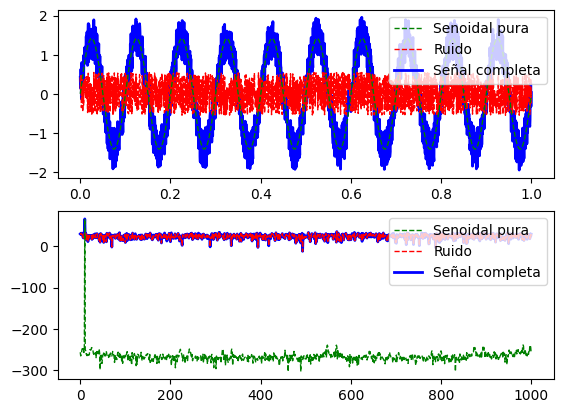

In [7]:
#%% Ploteo Senal original
plt.figure(1)
plt.subplot(2,1,1)

plt.plot( tt, xx,    '--g', linewidth=1, label="Senoidal pura",  zorder=3)
plt.plot( tt, noise, '--r', linewidth=1, label="Ruido",          zorder=2)
plt.plot( tt, xr,    'b',   linewidth=2, label="Señal completa", zorder=1)
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.plot( ff[bfrec], 10* np.log10(2*dp_sig),   '--g', linewidth=1, label="Senoidal pura", zorder=3)
plt.plot( ff[bfrec], 10* np.log10(2*dp_noise), '--r', linewidth=1, label="Ruido", zorder=2)
plt.plot( ff[bfrec], 10* np.log10(2*dp_XX),    'b',   linewidth=2, label="Señal completa", zorder=1)
plt.legend(loc='upper right')

#### Conversor analogico digital (Sin filtro anti aliasing)

##### Calculo de señal cuantizada, diezmada y salida del ADC (diezmada + cuantizada)

In [8]:
#%% ADC 
adc_q = 2*adc_vcc/(2**adc_bits)
#Cuantizacion
xr_cuantizado = np.round((xr+adc_vcc)/adc_q)*adc_q-adc_vcc
#Diezmado
xr_diezmado = xr[::os]
#Cuantizacion + Diezmado
xq = xr_cuantizado[::os]
adc_tt = tt[::os]
#Ruido de cuantizacion
nq = xr-xr_cuantizado

##### Ploteo de las señales del ADC

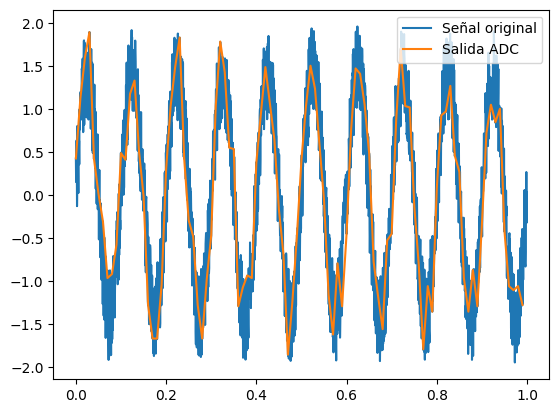

In [9]:
#%% Ploteo ADC
plt.figure(2)

plt.plot( tt,     xr, label="Señal original")
plt.plot( adc_tt, xq, label="Salida ADC")
plt.legend(loc='upper right')

##### Analisis del ruido de cuantizacion

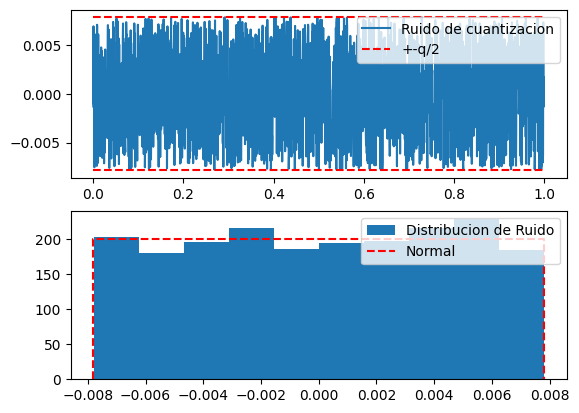

In [10]:
#%% Ploteo Ruido cuantizacion
plt.figure(3)

plt.subplot(2,1,1)
plt.plot( tt, nq, label="Ruido de cuantizacion")
#Limites de ruido
plt.plot( np.array([0, nn*Ts]), np.array([-adc_q/2, -adc_q/2]), '--r')
plt.plot( np.array([0, nn*Ts]), np.array([adc_q/2, adc_q/2]),   '--r', label="+-q/2" )
plt.legend(loc='upper right')

plt.subplot(2,1,2)
bins = 10
plt.hist( nq, bins=bins, label="Distribucion de Ruido")
#Funcion distribucion uniforme
plt.plot( np.array([-adc_q/2, -adc_q/2, adc_q/2, adc_q/2]), np.array([0, N/bins, N/bins, 0]), '--r', label="Normal")
plt.legend(loc='upper right')

#### Analisis de la densidad espectral de potencia de las señales (Sin filtro anti aliasing)
En este analisis podemos ver de manera grafica como se produce aliasing digital al diezmar la señal original oversampleada.
Como conclusión podemos decir que necesitamos un filtro anti aliasing antes del ADC.

##### Ploteo de las señales

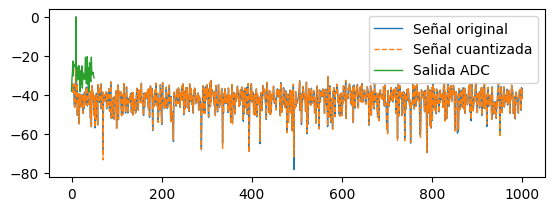

In [11]:
#%% Ploteo FFTs de las señales
N = nn
adc_nn= adc_fs
adc_df = adc_fs/adc_nn
ff = np.linspace(0, (N-1)*df, N)
adc_ff=np.linspace(0, (adc_nn-1)*adc_df, adc_nn)


bfrec = ff <= fs/2
bfrec2 = adc_ff <= adc_fs/2
fft_xr = np.fft.fft( xr, axis = 0 )*1/N
dp_xr = np.abs(fft_xr[bfrec])**2
fft_xr_cuantizado = np.fft.fft( xr_cuantizado, axis = 0 )*1/N
dp_xr_cuantizado = np.abs(fft_xr_cuantizado[bfrec])**2
fft_out = np.fft.fft( xq, axis = 0 )*1/adc_nn
dp_out = np.abs(fft_out[bfrec2])**2

plt.figure(4)
plt.subplot(2,1,1)
plt.plot( ff[bfrec],      10* np.log10(2*dp_xr),                  linewidth=1, label="Señal original")
plt.plot( ff[bfrec],      10* np.log10(2*dp_xr_cuantizado), '--', linewidth=1, label="Señal cuantizada")
plt.plot( adc_ff[bfrec2], 10* np.log10(2*dp_out),                 linewidth=1, label="Salida ADC")
plt.legend(loc='upper right')

##### Ploteo del ruido

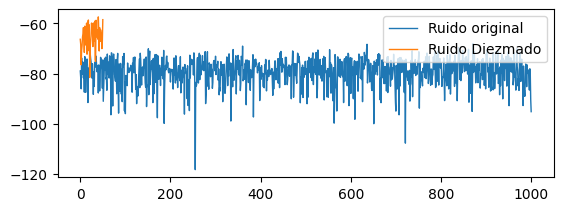

In [12]:
#%% Ploteo FFTs del ruido
fft_rq = np.fft.fft( nq, axis = 0 )*1/N
dp_rq = np.abs(fft_rq[bfrec])**2
fft_out = np.fft.fft( xq-xr_diezmado, axis = 0 )*1/adc_nn
dp_out = np.abs(fft_out[bfrec2])**2

plt.subplot(2,1,2)
plt.plot( ff[bfrec],      10* np.log10(2*dp_rq),  linewidth=1, label="Ruido original")
plt.plot( adc_ff[bfrec2], 10* np.log10(2*dp_out), linewidth=1, label="Ruido Diezmado")
plt.legend(loc='upper right')

#### Filtro anti-aliasing

##### Parametros del filtro

In [13]:
# Tipo de aproximación.
aprox_name = 'butter'

# Requerimientos de plantilla
filter_type = 'lowpass'

ftran = 0.1 
ripple = 0.5 # dB
attenuation = 40 # dB

##### Calculo del filtro

In [14]:
fstop = np.min([1/os + ftran/2, 1/os * 5/4])
fpass = np.max([fstop - ftran/2, fstop * 3/4])
# como usaremos filtrado bidireccional, alteramos las restricciones para
# ambas pasadas
ripple = ripple / 2 # dB
attenuation = attenuation / 2 # dB

if aprox_name == 'butter':
    # order, wcutof = sig.buttord( 2*np.pi*fpass*fs/2, 2*np.pi*fstop*fs/2, ripple, attenuation, analog=True)
    orderz, wcutofz = sig.buttord( fpass, fstop, ripple, attenuation, analog=False)

elif aprox_name == 'cheby1':
    # order, wcutof = sig.cheb1ord( 2*np.pi*fpass*fs/2, 2*np.pi*fstop*fs/2, ripple, attenuation, analog=True)
    orderz, wcutofz = sig.cheb1ord( fpass, fstop, ripple, attenuation, analog=False)
    
elif aprox_name == 'cheby2':
    # order, wcutof = sig.cheb2ord( 2*np.pi*fpass*fs/2, 2*np.pi*fstop*fs/2, ripple, attenuation, analog=True)
    orderz, wcutofz = sig.cheb2ord( fpass, fstop, ripple, attenuation, analog=False)
    
elif aprox_name == 'ellip':
    # order, wcutof = sig.ellipord( 2*np.pi*fpass*fs/2, 2*np.pi*fstop*fs/2, ripple, attenuation, analog=True)
    orderz, wcutofz = sig.ellipord( fpass, fstop, ripple, attenuation, analog=False)


# Diseño del filtro digital

filter_sos = sig.iirfilter(orderz, wcutofz, rp=ripple, rs=attenuation, 
                            btype=filter_type, 
                            analog=False, 
                            ftype=aprox_name,
                            output='sos')

##### Filtrado

In [15]:
xi = sig.sosfiltfilt(filter_sos, xr)

fft_Xi    = np.fft.fft( xi,    axis = 0 )
dp_Xi     = np.abs(fft_Xi[bfrec])**2

##### Ploteo de las señales filtradas

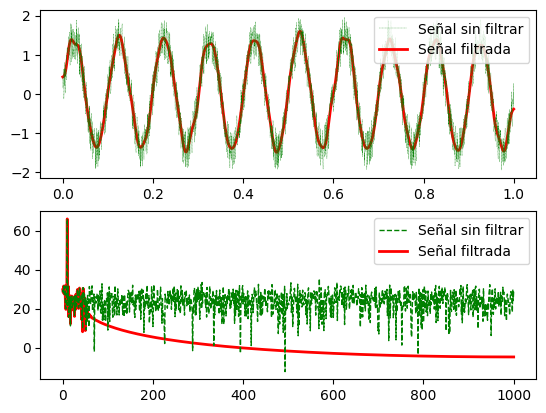

In [16]:
#%% Ploteo Senal
plt.figure(1)
plt.subplot(2,1,1)

plt.plot( tt, xr,    '--g', linewidth=0.2, label="Señal sin filtrar",  zorder=3)
plt.plot( tt, xi,    'r',   linewidth=2, label="Señal filtrada",     zorder=1)
plt.legend(loc='upper right')

plt.subplot(2,1,2)
plt.plot( ff[bfrec], 10* np.log10(2*dp_XX),    '--g',   linewidth=1, label="Señal sin filtrar", zorder=3)
plt.plot( ff[bfrec], 10* np.log10(2*dp_Xi),    'r',   linewidth=2, label="Señal filtrada", zorder=1)
plt.legend(loc='upper right')

#### Conversor analogico digital (con filtro anti alias)

##### Calculo de señal cuantizada, diezmada y salida del ADC (diezmada + cuantizada)

In [17]:
#%% ADC 
adc_q = 2*adc_vcc/(2**adc_bits)
#Cuantizacion
xi_cuantizado = np.round((xi)/adc_q)*adc_q
#Diezmado
xi_diezmado = xi[::os]
#Cuantizacion + Diezmado
xq = xi_cuantizado[::os]
adc_tt = tt[::os]
#Ruido de cuantizacion
nq = xi-xi_cuantizado

##### Ploteo de las señales del ADC

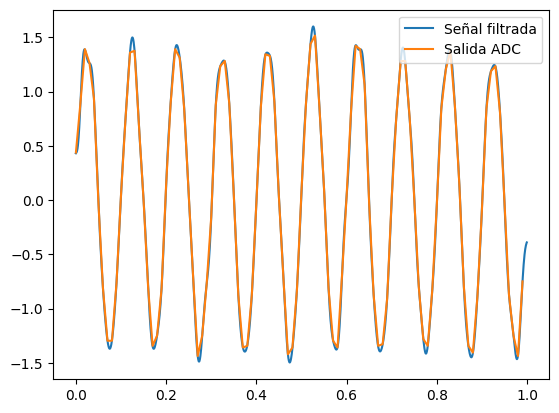

In [18]:
#%% Ploteo ADC
plt.figure(2)

plt.plot( tt,     xi, label="Señal filtrada")
plt.plot( adc_tt, xq, label="Salida ADC")
plt.legend(loc='upper right')

##### Analisis del ruido de cuantizacion

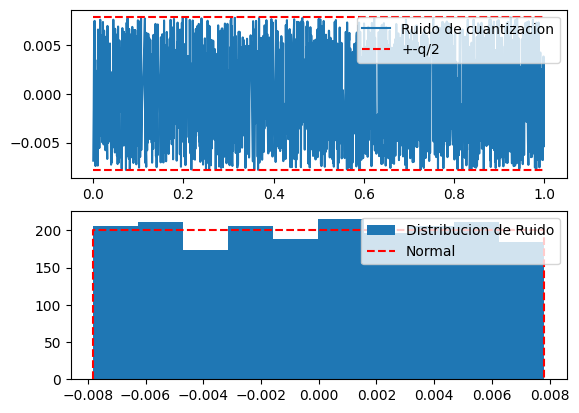

In [19]:
#%% Ploteo Ruido cuantizacion
plt.figure(3)

plt.subplot(2,1,1)
plt.plot( tt, nq, label="Ruido de cuantizacion")
#Limites de ruido
plt.plot( np.array([0, nn*Ts]), np.array([-adc_q/2, -adc_q/2]), '--r')
plt.plot( np.array([0, nn*Ts]), np.array([adc_q/2, adc_q/2]),   '--r', label="+-q/2" )
plt.legend(loc='upper right')

plt.subplot(2,1,2)
bins = 10
plt.hist( nq, bins=bins, label="Distribucion de Ruido")
#Funcion distribucion uniforme
plt.plot( np.array([-adc_q/2, -adc_q/2, adc_q/2, adc_q/2]), np.array([0, N/bins, N/bins, 0]), '--r', label="Normal")
plt.legend(loc='upper right')

#### Analisis de la densidad espectral de potencia de las señales (con filtro anti alias)

##### Ploteo de las señales

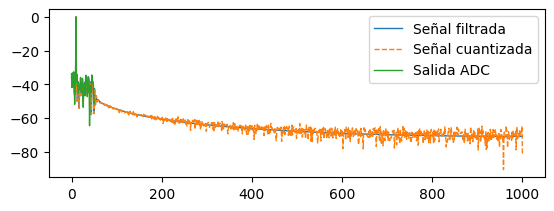

In [20]:
#%% Ploteo FFTs de las señales
N = nn
adc_nn= adc_fs
adc_df = adc_fs/adc_nn
ff = np.linspace(0, (N-1)*df, N)
adc_ff=np.linspace(0, (adc_nn-1)*adc_df, adc_nn)

bfrec = ff <= fs/2
bfrec2 = adc_ff <= adc_fs/2
fft_xi = np.fft.fft( xi, axis = 0 )*1/N
dp_xi = np.abs(fft_xi[bfrec])**2
fft_xi_cuantizado = np.fft.fft( xi_cuantizado, axis = 0 )*1/N
dp_xi_cuantizado = np.abs(fft_xi_cuantizado[bfrec])**2
fft_out = np.fft.fft( xq, axis = 0 )*1/adc_nn
dp_out = np.abs(fft_out[bfrec2])**2

plt.figure(4)
plt.subplot(2,1,1)
plt.plot( ff[bfrec],      10* np.log10(2*dp_xi),                  linewidth=1, label="Señal filtrada")
plt.plot( ff[bfrec],      10* np.log10(2*dp_xi_cuantizado), '--', linewidth=1, label="Señal cuantizada")
plt.plot( adc_ff[bfrec2], 10* np.log10(2*dp_out),                 linewidth=1, label="Salida ADC")
plt.legend(loc='upper right')